# Resolution Analysis using Phantoms

Author: Aniket Tekawade, Argonne National Laboratory  
The analysis in this notebook was presented at the following meeting. Please cite accordingly.  

Aniket Tekawade, Brandon A. Sforzo, Alan L. Kastengren, and Christopher F. Powell "Synchrotron x-ray tomography for non-destructive metrology of micro-orifices in automotive fuel injectors (Conference Presentation)", Proc. SPIE 11382, Smart Structures and NDE for Industry 4.0, Smart Cities, and Energy Systems, 1138207 (27 April 2020); https://doi.org/10.1117/12.2558643  

In [1]:
import sys
import os
import numpy as np
import pandas as pd

import h5py
import time

from scipy.ndimage.filters import median_filter
from scipy.ndimage import gaussian_filter
from ImageStackPy import Img_Viewer as VIEW
from ImageStackPy import ImageProcessing as IP

import matplotlib.pyplot as plt
import matplotlib as mpl

# from fname_utils import df, get_filename
from ct_segnet.data_utils import data_io
from ct_segnet import viewer
from ct_segnet import seg_utils
from tqdm import tqdm
%matplotlib notebook

from ct_segnet.seg_utils import Segmenter
from ct_segnet.stats import calc_SNR
model_path = '../model_repo'
df = pd.read_csv(os.path.join(model_path, "models.csv"))

### Define SNR calculation using segmented image
Either ground truth or predicted image - we will extract mean value in each phase and stretch the intensity profile such that the mean value of "metal" voxels is 1 and those of "air" is 0.

## Noise-Resolution Correlation using Mandelbrot Fractals

<IPython.core.display.Javascript object>


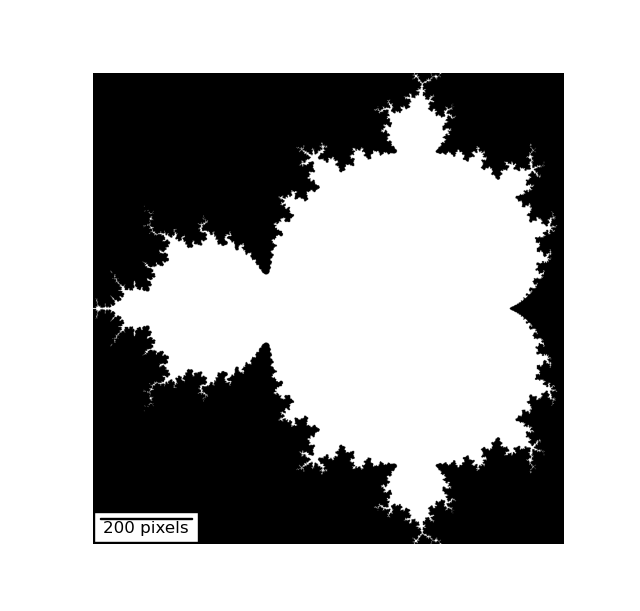

(1024, 1024)


In [2]:
# https://tomroelandts.com/articles/how-to-compute-the-mandelbrot-set-using-numpy-array-operations
m = 1536#480*2
n = 1024#320*2

from tqdm import trange
def get_mandelbrot(niters = 20, shape = (1024,1536)):
    n, m = shape
    x = np.linspace(-2, 1, num=m).reshape((1, m))
    y = np.linspace(-1, 1, num=n).reshape((n, 1))
    C = np.tile(x, (n, 1)) + 1j * np.tile(y, (1, m))

    Z = np.zeros((n, m), dtype=complex)
    M = np.full((n, m), True, dtype=bool)
#     Mf = np.full((n, m), 0, dtype=np.uint16)

    for i in range(niters):
        Z[M] = Z[M] * Z[M] + C[M]
        M[np.abs(Z) > 2] = False
#         Mf[M] = i
    M = np.uint8(np.flipud(M))
    M = np.copy(M[:,256:-256])
    return M

def add_noise(M, SNR):
    return np.copy(M) + np.random.normal(0, 1/SNR, M.shape)

fig, ax = plt.subplots(1,1)
M = get_mandelbrot(niters = 20)
ax.imshow(M, cmap = 'gray')
ax.axis('off')
viewer.add_scalebar(ax, 200, 1, units = 'pixels', loc = 'lower left', fontsize = 12)
print(M.shape)

# ax.imshow(M[plot_s[0], plot_s[1]], cmap = 'gray')
# ax.axis('off')


### How does the histogram look like for different SNR?

<IPython.core.display.Javascript object>


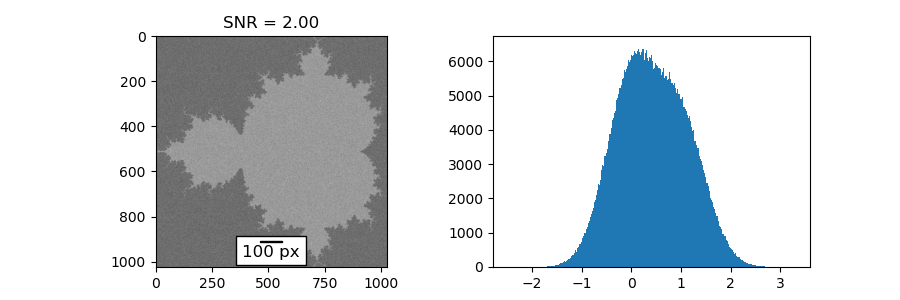

(1024, 1024)


In [3]:
SNR = 2.0
N = add_noise(M, SNR)
fig, ax = plt.subplots(1,2, figsize = (9,3))
ax[0].imshow(N, cmap = 'gray')
viewer.add_scalebar(ax[0], 100, 1, units = 'px', fontsize = 12)
ax[1].hist(N.reshape(-1), bins = 500)
ax[0].set_title("SNR = %.2f"%calc_SNR(N, M))
print(N.shape)

<IPython.core.display.Javascript object>


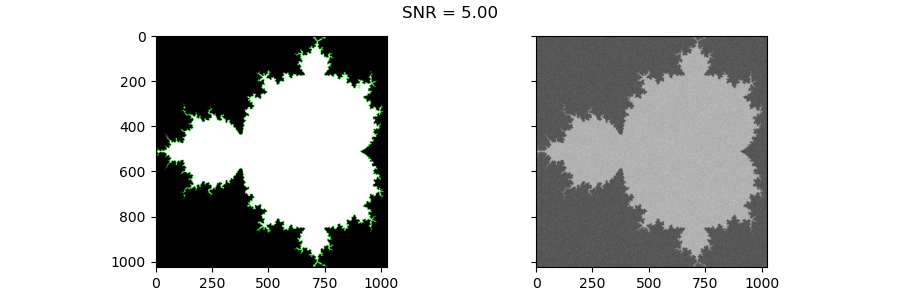

Text(0.5, 0.98, 'SNR = 5.00')

In [4]:
segmenter = Segmenter(model_filename = os.path.join(model_path, 'M_b02_242_512.hdf5'))
SNR = 5.0
N = add_noise(M, SNR)
S = segmenter.seg_image(N, max_patches = (2,2), overlap = 20)
fig, ax = plt.subplots(1,2, sharex = True, sharey = True, figsize = (9,3))
viewer.edge_plot(M, S, ax[0])
ax[1].imshow(N, cmap = 'gray')
fig.suptitle("SNR = %.2f"%calc_SNR(N, M))

## Make a nice plot for presentation

<IPython.core.display.Javascript object>


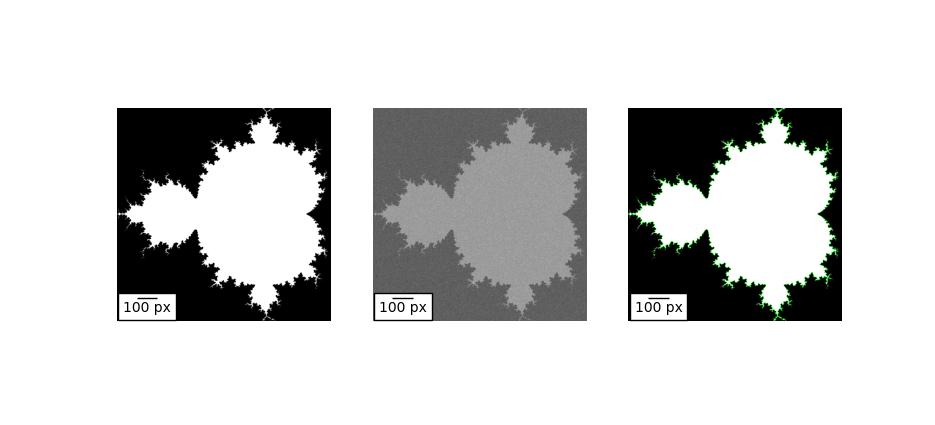

(1024, 1024)


In [5]:
fig, ax = plt.subplots(1,3, sharex = True, sharey = True)
M = get_mandelbrot(niters = 20)
N = add_noise(M, 3.0)

ax[0].imshow(M, cmap = 'gray')
ax[0].axis('off')
viewer.add_scalebar(ax[0], 100, 1, units = 'px', loc = 'lower left', fontsize = 10)

ax[1].imshow(N, cmap = 'gray')
ax[1].axis('off')
viewer.add_scalebar(ax[1], 100, 1, units = 'px', loc = 'lower left', fontsize = 10)

S = segmenter.seg_image(N, max_patches = (2,2), overlap = 20)
viewer.edge_plot(M, S, ax[2])
viewer.add_scalebar(ax[2], 100, 1, units = 'px', loc = 'lower left', fontsize = 10)
ax[2].axis('off')


print(M.shape)



<IPython.core.display.Javascript object>


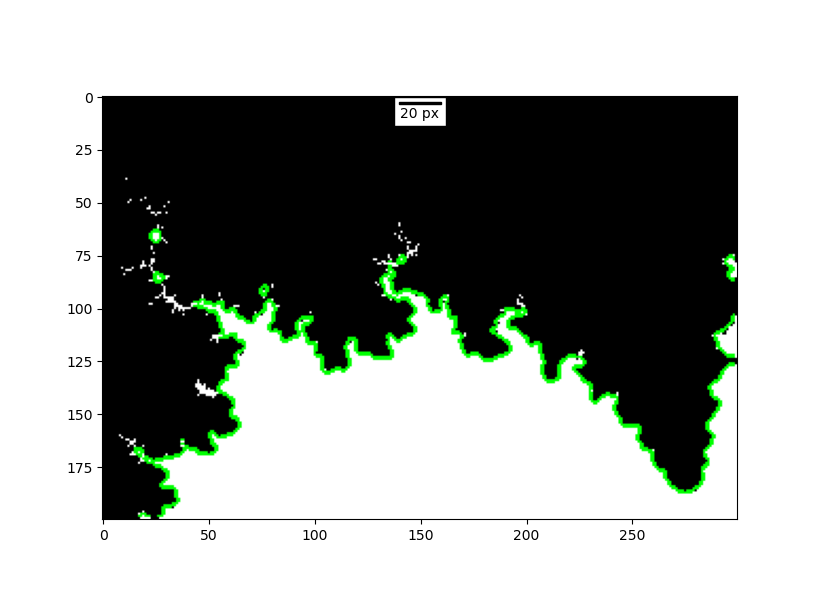

In [6]:
plot_s = slice(250,450), slice(100,400)
fig, ax = plt.subplots(1,1)
viewer.edge_plot(M[plot_s[0], plot_s[1]], S[plot_s[0], plot_s[1]], ax)
viewer.add_scalebar(ax, 20, 1, units = 'px', loc = 'upper center', fontsize = 10)
# ax.axis('off')


<IPython.core.display.Javascript object>


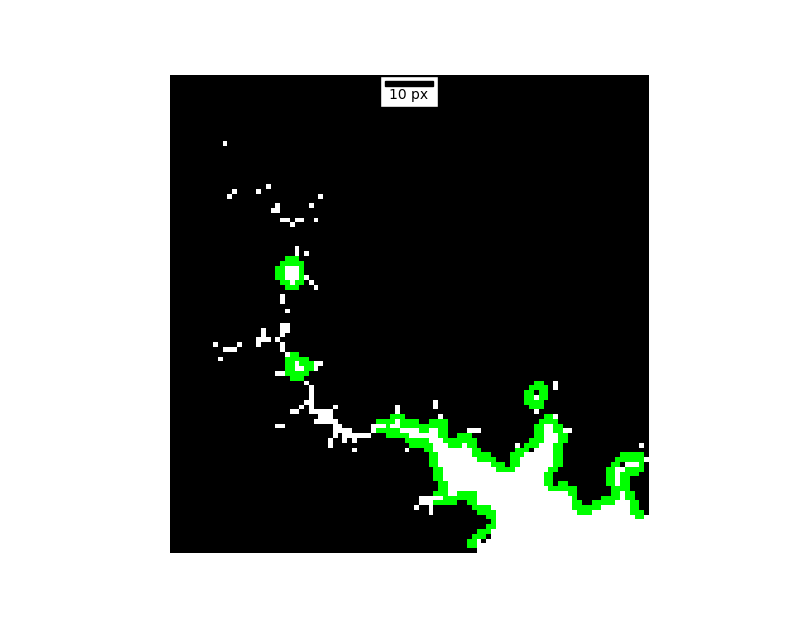

(-0.5, 99.5, 99.5, -0.5)

In [7]:
plot_s = slice(275,250+125), slice(100,200)
fig, ax = plt.subplots(1,1)
viewer.edge_plot(M[plot_s[0], plot_s[1]], S[plot_s[0], plot_s[1]], ax)
viewer.add_scalebar(ax, 10, 1, units = 'px', loc = 'upper center', fontsize = 10)
ax.axis('off')


### How does SNR - accuracy vary with models?

In [8]:
# Setup stuff
from ct_segnet.train_utils import calc_jac_acc as metric
model_names = list(df["name"])#['M_a01_242_512', 'M_b01_242_512']
M = get_mandelbrot(niters = 20)

In [9]:
print("These are the models in our repository")
model_names

These are the models in our repository


['M_a01_242_512', 'M_a02_242_512', 'M_a03_2222_512', 'M_d01_222_256']

In [10]:
SNR_list = np.linspace(25, 1, 25, endpoint=True)
metric_list = np.asarray([np.zeros_like(SNR_list)]*len(model_names))
pbar = tqdm(total = np.prod(metric_list.shape))
for j, model_name in enumerate(model_names):
    segmenter = Segmenter(model_filename = os.path.join(model_path, model_name + ".hdf5"))    
    for i, SNR in enumerate(SNR_list):
        N = add_noise(M, SNR)
        S = segmenter.seg_image(N, max_patches = (2,2), overlap = 20)
        if "M_c" in model_name:
            S = (~S.astype(bool)).astype(np.uint8)
        metric_list[j,i] = metric(M, S)
        pbar.update(1)
pbar.close()
print("\n")


100%|██████████| 100/100 [00:22<00:00,  4.49it/s]

<IPython.core.display.Javascript object>


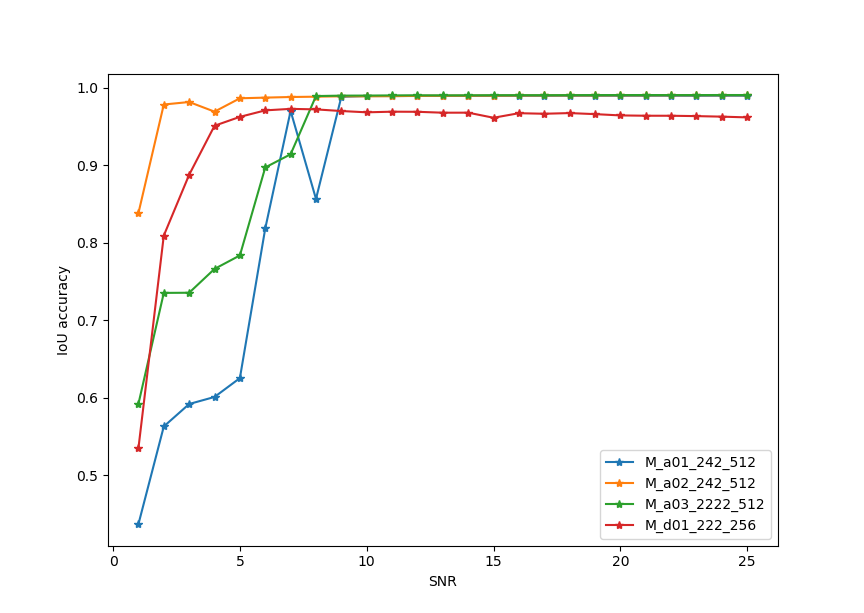

In [11]:
fig, ax = plt.subplots(1,1)
for j, model_name in enumerate(model_names):
#     if "M_d" not in model_name: continue
    ax.plot(SNR_list, metric_list[j], '*-', label = model_names[j])
#     ax.set_xticks(np.linspace(1,25,5).tolist())
#     ax.set_xlim([1,4])
ax.set_xlabel("SNR")
ax.set_ylabel("IoU accuracy")
ax.legend(loc = 'lower right')

### Which accuracy metric measures resolution?
Let's lock down on model M_b02_242_512  
1. Vary fractal size
2. Vary metrics


In [12]:
# Setup stuff
model_name = 'M_b02_242_512'
from ct_segnet.train_utils import calc_dice_coeff, calc_jac_acc
segmenter = Segmenter(model_filename = os.path.join(model_path, model_name + ".hdf5"))
M = get_mandelbrot(niters = 20)

### Vary metrics (IoU, Dice, Dice Edge)

In [13]:
# Define Dice Edge Metric
# https://github.com/tomochallenge/tomochallenge_utils/blob/master/foam_phantom_utils.py
def get_edgemap(img):
    msk = np.zeros_like(img)
    tmp = img[1:] != img[:-1]
    msk[:-1][tmp] = 1
    msk[1:][tmp] = 1
    tmp = img[:,:-1]!= img[:,1:]
    msk[:,:-1][tmp] = 1
    msk[:,1:][tmp] = 1
    return msk

def calc_dice_edge(y_true, y_pred):
    edge_map = get_edgemap(y_true)
    edge_true = y_true[edge_map > 0]
    edge_pred = y_pred[edge_map > 0]
    return calc_dice_coeff(edge_true, edge_pred)
    
    

<IPython.core.display.Javascript object>


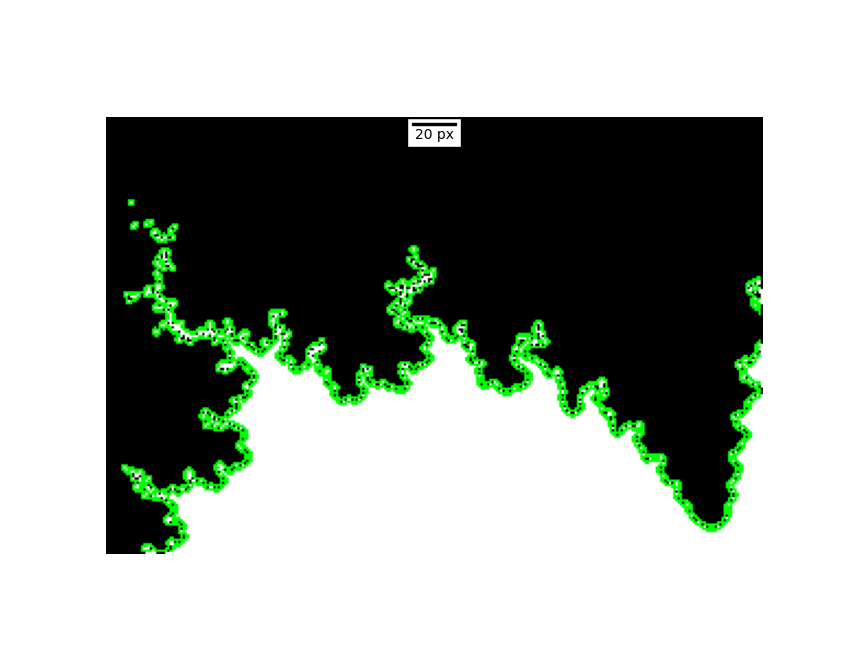

(-0.5, 299.5, 199.5, -0.5)

In [14]:
plot_s = slice(250,450), slice(100,400)
fig, ax = plt.subplots(1,1)
E = get_edgemap(M)
viewer.edge_plot(M[plot_s[0], plot_s[1]], E[plot_s[0], plot_s[1]], ax)
viewer.add_scalebar(ax, 20, 1, units = 'px', loc = 'upper center', fontsize = 10)
ax.axis('off')


In [15]:
# metrics = [calc_dice_coeff, calc_jac_acc, calc_dice_edge]
metrics = [calc_dice_coeff]
SNR_list = np.linspace(5, 1, 20, endpoint=True)
metric_list = np.asarray([np.zeros_like(SNR_list)]*len(metrics))

pbar = tqdm(total = np.prod(metric_list.shape))
for j, metric in enumerate(metrics):
    for i, SNR in enumerate(SNR_list):
        _metric = np.zeros(20)
        for k in range(20):
            N = add_noise(M, SNR)
            S = segmenter.seg_image(N, max_patches = (2,2), overlap = 20)
            if "M_c" in model_name:
                S = (~S.astype(bool)).astype(np.uint8)
            _metric[k] = metric(M, S)
        metric_list[j,i] = np.mean(_metric)
        pbar.update(1)
pbar.close()
print("\n")


100%|██████████| 20/20 [00:54<00:00,  2.74s/it]

<IPython.core.display.Javascript object>


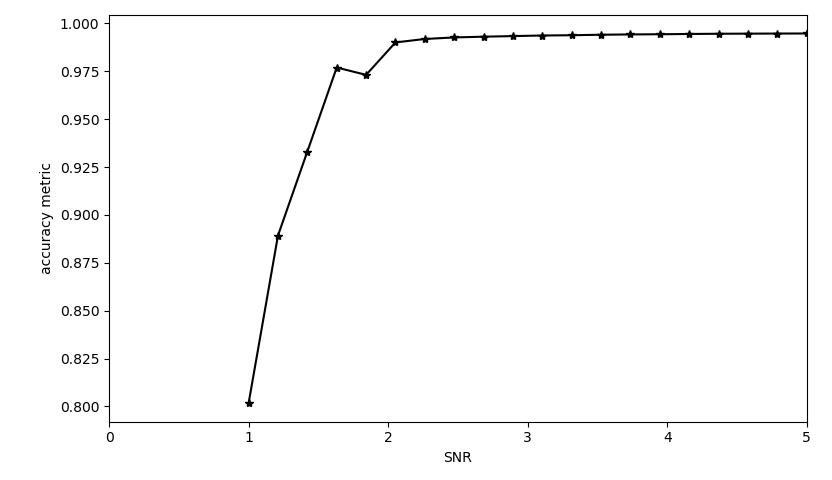

In [16]:
fig, ax = plt.subplots(1,1)
for j, metric in enumerate(metrics):
    ax.plot(SNR_list, metric_list[j], '*-', label = metric.__name__.split("calc_")[-1], color = 'black')
#     ax.set_xticks(np.linspace(1,25,5).tolist())
    ax.set_xlim([0,5])
ax.set_xlabel("SNR")
ax.set_ylabel("accuracy metric")
# ax.legend(loc = 'lower right')
fig.tight_layout()

### With blurring

In [17]:
n_reps = 11
def do_nothing(inp):
    return inp
from functools import partial
M = get_mandelbrot(niters = 20)
metric = calc_dice_coeff
SNR_list = np.linspace(5, 1, 20, endpoint=True)
blurs = [do_nothing, partial(median_filter, size = 5), partial(gaussian_filter, sigma = 2)]
labels = ["unfiltered", "median k = 5", "gaussian sigma = 2"]
metric_list = np.asarray([np.zeros_like(SNR_list)]*len(blurs))

pbar = tqdm(total = np.prod(metric_list.shape))
for j, blur in enumerate(blurs):
    for i, SNR in enumerate(SNR_list):
        _metric = np.zeros(n_reps)
        for k in range(n_reps):
            N = add_noise(M, SNR)
            N = blur(N)
            S = segmenter.seg_image(N, max_patches = (2,2), overlap = 20)
            if "M_c" in model_name:
                S = (~S.astype(bool)).astype(np.uint8)
            _metric[k] = metric(M, S)
        metric_list[j,i] = np.mean(_metric)
        pbar.update(1)
pbar.close()
print("\n")



100%|██████████| 60/60 [03:04<00:00,  3.07s/it]

<IPython.core.display.Javascript object>


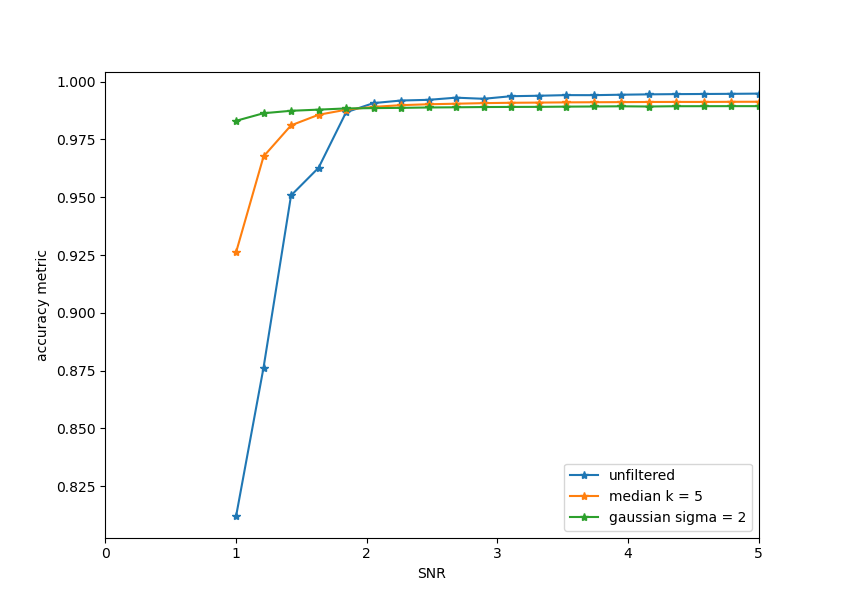

In [18]:
fig, ax = plt.subplots(1,1)
for j, blur in enumerate(blurs):
    ax.plot(SNR_list, metric_list[j], '*-', label = labels[j])
#     ax.set_xticks(np.linspace(1,25,5).tolist())
    ax.set_xlim([0,5])
ax.set_xlabel("SNR")
ax.set_ylabel("accuracy metric")
ax.legend(loc = 'lower right')

<IPython.core.display.Javascript object>


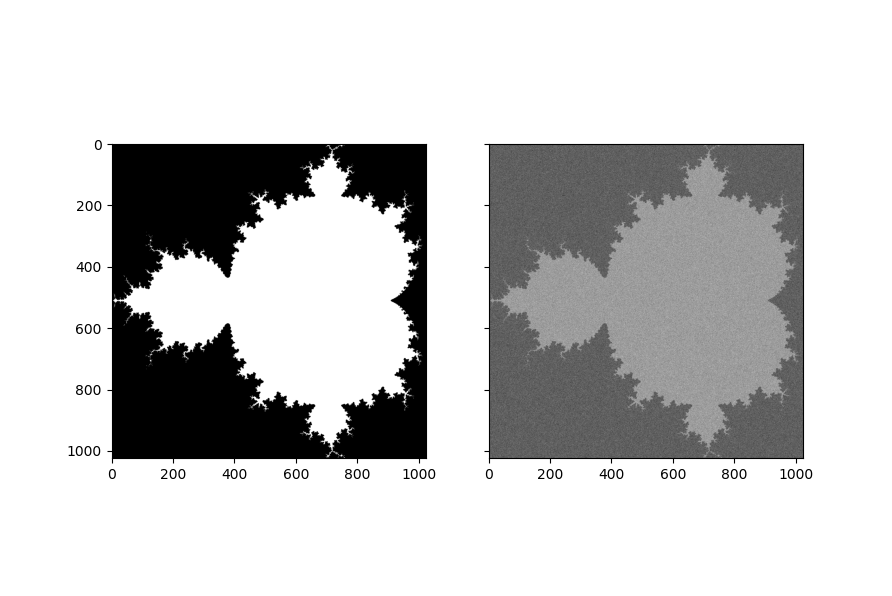

0.9937221506860832


In [19]:
N = add_noise(M, 3.0)
N = blurs[0](N)
S = segmenter.seg_image(N, max_patches = (2,2), overlap = 20)
fig, ax = plt.subplots(1,2, sharex = True, sharey = True)
ax[0].imshow(M, cmap = 'gray')
ax[1].imshow(N, cmap = 'gray')
print(metric(M, S))

### Vary fractal parameter

In [20]:
SNR = 1.5
metric = calc_dice_edge
iter_list = [5, 10, 20, 40, 80, 160, 320,640]
metric_list = np.zeros(len(iter_list))

pbar = tqdm(total = np.prod(metric_list.shape))
for i, n in enumerate(iter_list):
    M = get_mandelbrot(niters = n)
    N = add_noise(M, SNR)
    S = segmenter.seg_image(N, max_patches = (2,2), overlap = 20)
    metric_list[i] = metric(M, S)
    pbar.update(1)
#     print(M.shape)
pbar.close()

100%|██████████| 8/8 [00:34<00:00,  4.28s/it]


<IPython.core.display.Javascript object>


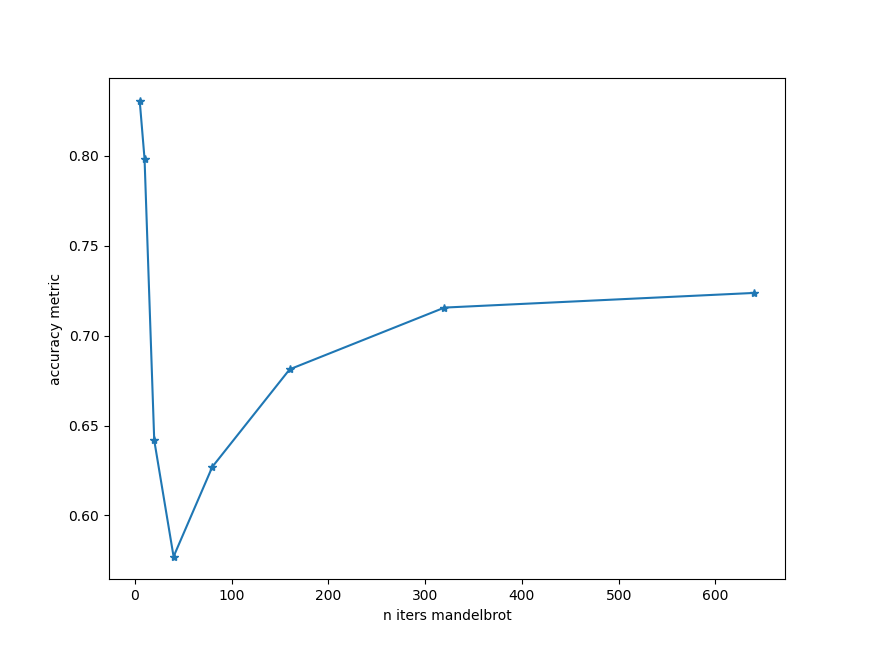

Text(0, 0.5, 'accuracy metric')

In [21]:
fig, ax = plt.subplots(1,1)
ax.plot(iter_list, metric_list, '*-')
ax.set_xlabel("n iters mandelbrot")
ax.set_ylabel("accuracy metric")

### Let's make two touching circles

In [22]:
def circ_mask(center, radius = 100, img_shape = (512,512)):
    yc, xc = center
    xx, yy = np.meshgrid(np.arange(img_shape[0]) - yc, \
                         np.arange(img_shape[1]) - xc, indexing = 'ij')
    dist = np.sqrt(xx**2 + yy**2)
    return dist < radius

def two_circles(yc = 256, xt = 256, radius = 128, img_shape = (512,512)):
    """
    param xt: x coordinate of overlap
    param yc: y coordinate of circle center
    """
    circ1 = circ_mask((yc,xt-radius), radius = radius, img_shape = img_shape)
    circ2 = circ_mask((yc,xt+radius), radius = radius, img_shape = img_shape)
    two_circ = circ1 | circ2
    two_circ = two_circ.astype(np.uint8)
    return two_circ
    
    

<IPython.core.display.Javascript object>


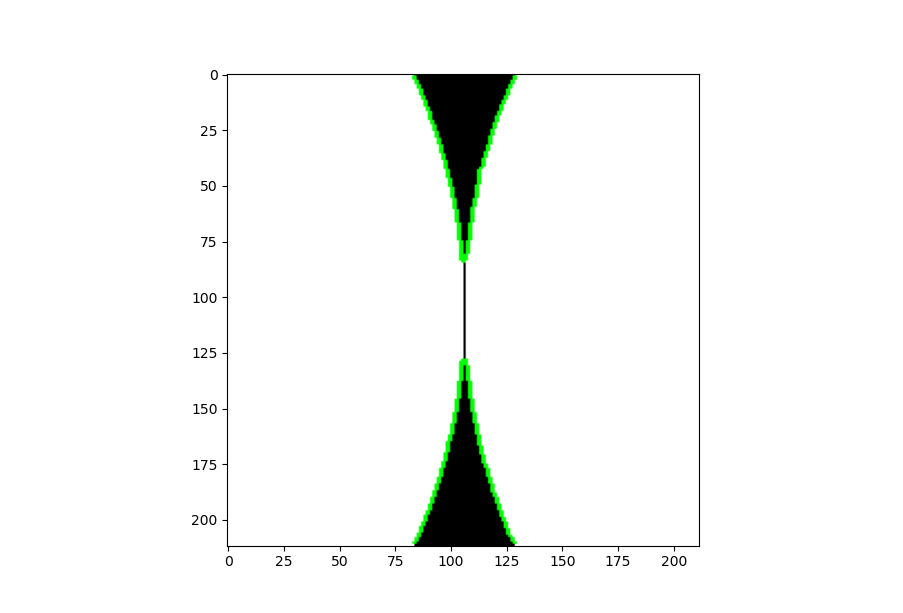

In [23]:
SNR = 5.0
D = 512
M = two_circles(yc = 256, xt = 256,radius = D//2, img_shape = (512,512))
N = add_noise(M, SNR)
S = segmenter.seg_image(N, max_patches = (1,1))

fig, ax = plt.subplots(1,1)
s = slice(150,-150)
viewer.edge_plot(M[s,s], S[s,s], ax)
def get_h(M, SNR, blur = False):
    N = add_noise(M, SNR)
    if blur:
        N = IP.XY_medianBlur(N, X_kern_size = 7)[0]
    S = segmenter.seg_image(N, max_patches = (1,1))
    sx = slice(256-50,256+50)
    l = np.sum(S[sx,sx], axis = 0)
    d = np.min(l)
    h = D - np.sqrt(D**2 - d**2)
    return h

100%|██████████| 20/20 [00:46<00:00,  2.31s/it]


<IPython.core.display.Javascript object>


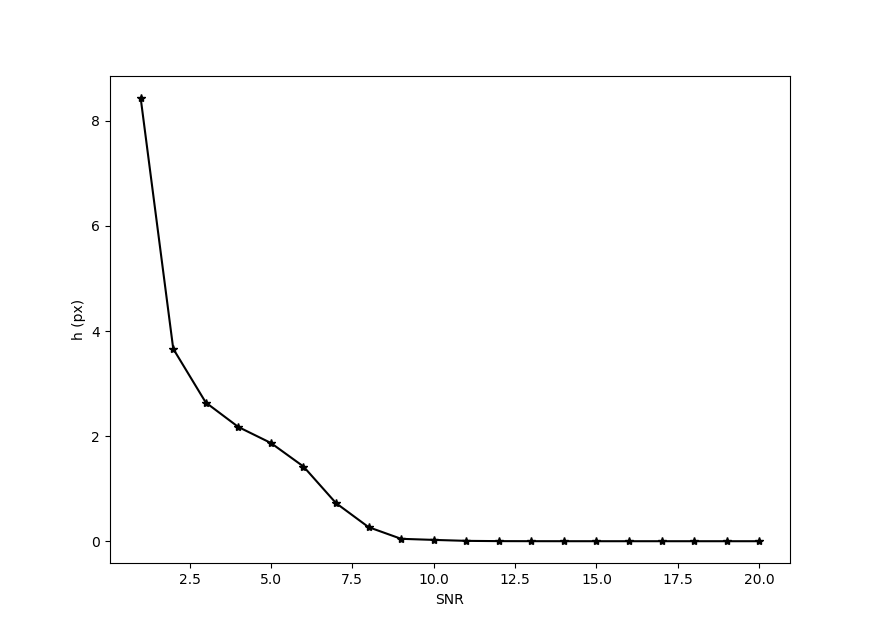

Text(0, 0.5, 'h (px)')

In [24]:
SNR_list = np.linspace(20,1,20)
h_list = np.zeros_like(SNR_list)
pbar = tqdm(total = len(SNR_list))
for i, SNR in enumerate(SNR_list):
    h_list[i] = np.mean([get_h(M, SNR) for j in range(40)], axis = 0)
    pbar.update(1)
pbar.close()
fig, ax = plt.subplots(1,1)
ax.plot(SNR_list, h_list, '*-', color = 'black')
ax.set_xlabel("SNR")
ax.set_ylabel("h (px)")

### What if we applied a median filter before segmentation?

100%|██████████| 20/20 [01:26<00:00,  4.35s/it]


<IPython.core.display.Javascript object>


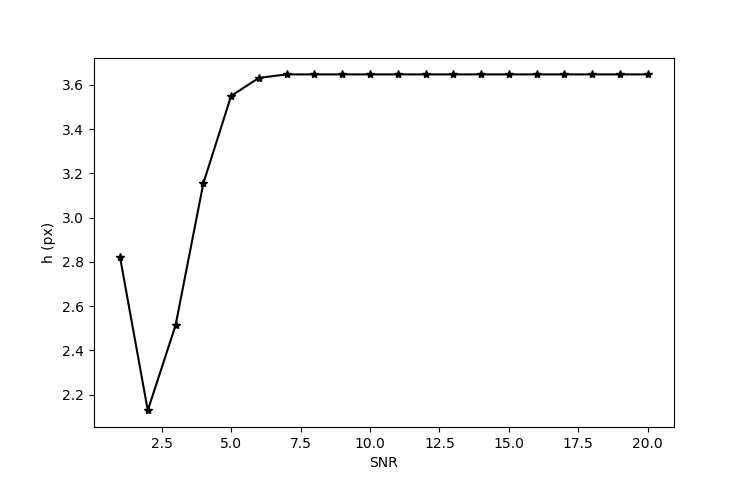

Text(0, 0.5, 'h (px)')

In [25]:
SNR_list = np.linspace(20,1,20)
h_list = np.zeros_like(SNR_list)
pbar = tqdm(total = len(SNR_list))
for i, SNR in enumerate(SNR_list):
    h_list[i] = np.mean([get_h(M, SNR, blur = True) for j in range(30)], axis = 0)
    pbar.update(1)
pbar.close()
fig, ax = plt.subplots(1,1)
ax.plot(SNR_list, h_list, '*-', color = 'black')
ax.set_xlabel("SNR")
ax.set_ylabel("h (px)")